In [89]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [90]:
# !cp '/content/drive/MyDrive/spectrograms.zip' .

In [91]:
# !unzip -q spectrograms.zip

In [92]:
# !pip list

In [93]:
# !rm -r /content/logs

In [94]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

# tf.config.run_functions_eagerly(True)

In [95]:
SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 25
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 50
EPOCHS = 75

NUM_TRAIN = 900
NUM_VAL = 500
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

NUM_LANGUAGES = 1
LANGUAGES = ['EN','ES','FR','DE','CA']

LOG_DIR = "/content/logs/model" + str(NUM_LANGUAGES) + "-"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.0001

In [96]:
BASE_DIR_EN = '/content/spectrograms/en/clips/'
TRAIN_PATH_EN = '/content/spectrograms/en/train.tsv'
TEST_PATH_EN = '/content/spectrograms/en/test.tsv'
VAL_PATH_EN = '/content/spectrograms/en/val.tsv'

NUM_TRAIN_EN = NUM_TRAIN
NUM_VAL_EN = NUM_VAL
NUM_TEST_EN = NUM_TEST

LABELS_EN = ['zero','one','two','three','four','five','six','seven','eight','nine','ten','Hey','yes','no','Firefox']
NUM_LABELS_EN = len(LABELS_EN)

In [97]:
BASE_DIR_ES = '/content/spectrograms/es/clips/'
TRAIN_PATH_ES = '/content/spectrograms/es/train.tsv'
TEST_PATH_ES = '/content/spectrograms/es/test.tsv'
VAL_PATH_ES = '/content/spectrograms/es/val.tsv'

NUM_TRAIN_ES = NUM_TRAIN
NUM_VAL_ES = NUM_VAL
NUM_TEST_ES = NUM_TEST

LABELS_ES = ['cero','cinco','cuatro','dos','Firefox','Hey','no','neuve','ocho','seis','siete','tres','uno','sí']
NUM_LABELS_ES = len(LABELS_ES)

In [98]:
BASE_DIR_FR = '/content/spectrograms/fr/clips/'
TRAIN_PATH_FR = '/content/spectrograms/fr/train.tsv'
TEST_PATH_FR = '/content/spectrograms/fr/test.tsv'
VAL_PATH_FR = '/content/spectrograms/fr/val.tsv'

NUM_TRAIN_FR = NUM_TRAIN
NUM_VAL_FR = NUM_VAL
NUM_TEST_FR = NUM_TEST

LABELS_FR = ['zéro','un','deux','trois','quatre','cinq','six','sept','huit','neuf','dix','Hey','oui','non','Firefox']
NUM_LABELS_FR = len(LABELS_FR)

In [99]:
BASE_DIR_DE = '/content/spectrograms/de/clips/'
TRAIN_PATH_DE = '/content/spectrograms/de/train.tsv'
TEST_PATH_DE = '/content/spectrograms/de/test.tsv'
VAL_PATH_DE = '/content/spectrograms/de/val.tsv'

NUM_TRAIN_DE = NUM_TRAIN
NUM_VAL_DE = NUM_VAL
NUM_TEST_DE = NUM_TEST

LABELS_DE = ['zwei','vier','sieben','sechs','neun','nein','nan','ja','fünf','eins','drei','acht','Hey','Hei','Firefox']
NUM_LABELS_DE = len(LABELS_DE)

In [100]:
BASE_DIR_CA = '/content/spectrograms/ca/clips/'
TRAIN_PATH_CA = '/content/spectrograms/ca/train.tsv'
TEST_PATH_CA = '/content/spectrograms/ca/test.tsv'
VAL_PATH_CA = '/content/spectrograms/ca/val.tsv'

NUM_TRAIN_CA = NUM_TRAIN
NUM_VAL_CA = NUM_VAL
NUM_TEST_CA = NUM_TEST

LABELS_CA = ['Ei','Firefox','cinc','dos','no','nou','quatre','set','sis','sí','tres','u','vuit','zero']
NUM_LABELS_CA = len(LABELS_CA)

In [101]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

# def processdata(file):
#     waveform,sample_rate = librosa.load(file, SAMPLE_RATE)
#     waveform = padaudio(waveform)
#     mfccs = librosa.feature.mfcc(waveform,sr=sample_rate,n_mfcc=N_MFCC)
#     mfccs = np.moveaxis(mfccs,1,0)
#     scaler = StandardScaler()
#     mfccs_scaled = scaler.fit_transform(mfccs)
#     return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1],1)

def processdata(file):
  filename = file.split(".")[0] + '.pkl'
  with open(filename,'rb') as f:
    spectrogram = pickle.load(f)

  return spectrogram

In [102]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [103]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [104]:
dftrainEN = pd.read_csv(TRAIN_PATH_EN, sep='\t', header=0)
dftrainEN.sort_values(by='length',ascending=False,inplace=True)
trainxEN,trainyEN, = getdata(dftrainEN.head(NUM_TRAIN_EN), BASE_DIR_EN)

dfvalEN = pd.read_csv(VAL_PATH_EN, sep='\t', header=0)
dfvalEN.sort_values(by='length',ascending=False,inplace=True)
valxEN,valyEN, = getdata(dfvalEN.head(NUM_VAL_EN), BASE_DIR_EN)

dftestEN = pd.read_csv(TEST_PATH_EN, sep='\t', header=0)
dftestEN.sort_values(by='length',ascending=False,inplace=True)
testxEN,testyEN, = getdata(dftestEN.head(NUM_TEST_EN), BASE_DIR_EN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [105]:
dftrainES = pd.read_csv(TRAIN_PATH_ES, sep='\t', header=0)
dftrainES.sort_values(by='length',ascending=False,inplace=True)
trainxES,trainyES, = getdata(dftrainES.head(NUM_TRAIN_ES), BASE_DIR_ES)

dfvalES = pd.read_csv(VAL_PATH_ES, sep='\t', header=0)
dfvalES.sort_values(by='length',ascending=False,inplace=True)
valxES,valyES, = getdata(dfvalES.head(NUM_VAL_ES), BASE_DIR_ES)

dftestES = pd.read_csv(TEST_PATH_ES, sep='\t', header=0)
dftestES.sort_values(by='length',ascending=False,inplace=True)
testxES,testyES, = getdata(dftestES.head(NUM_TEST_ES), BASE_DIR_ES)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [106]:
dftrainFR = pd.read_csv(TRAIN_PATH_FR, sep='\t', header=0)
dftrainFR.sort_values(by='length',ascending=False,inplace=True)
trainxFR,trainyFR, = getdata(dftrainFR.head(NUM_TRAIN_FR), BASE_DIR_FR)

dfvalFR = pd.read_csv(VAL_PATH_FR, sep='\t', header=0)
dfvalFR.sort_values(by='length',ascending=False,inplace=True)
valxFR,valyFR, = getdata(dfvalFR.head(NUM_VAL_FR), BASE_DIR_FR)

dftestFR = pd.read_csv(TEST_PATH_FR, sep='\t', header=0)
dftestFR.sort_values(by='length',ascending=False,inplace=True)
testxFR,testyFR, = getdata(dftestFR.head(NUM_TEST_FR), BASE_DIR_FR)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
dftrainDE = pd.read_csv(TRAIN_PATH_DE, sep='\t', header=0)
dftrainDE.sort_values(by='length',ascending=False,inplace=True)
trainxDE,trainyDE, = getdata(dftrainDE.head(NUM_TRAIN_DE), BASE_DIR_DE)

dfvalDE = pd.read_csv(VAL_PATH_DE, sep='\t', header=0)
dfvalDE.sort_values(by='length',ascending=False,inplace=True)
valxDE,valyDE, = getdata(dfvalDE.head(NUM_VAL_DE), BASE_DIR_DE)

dftestDE = pd.read_csv(TEST_PATH_DE, sep='\t', header=0)
dftestDE.sort_values(by='length',ascending=False,inplace=True)
testxDE,testyDE, = getdata(dftestDE.head(NUM_TEST_DE), BASE_DIR_DE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
dftrainCA = pd.read_csv(TRAIN_PATH_CA, sep='\t', header=0)
dftrainCA.sort_values(by='length',ascending=False,inplace=True)
trainxCA,trainyCA, = getdata(dftrainCA.head(NUM_TRAIN_CA), BASE_DIR_CA)

dfvalCA = pd.read_csv(VAL_PATH_CA, sep='\t', header=0)
dfvalCA.sort_values(by='length',ascending=False,inplace=True)
valxCA,valyCA, = getdata(dfvalCA.head(NUM_VAL_CA), BASE_DIR_CA)

dftestCA = pd.read_csv(TEST_PATH_CA, sep='\t', header=0)
dftestCA.sort_values(by='length',ascending=False,inplace=True)
testxCA,testyCA, = getdata(dftestCA.head(NUM_TEST_CA), BASE_DIR_CA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[15]])
traingenshapes = (xshapes,yshapes)

In [110]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [111]:
trainxsEN = [trainxEN]
trainysEN = [[trainyEN,LABELS_EN]]

trainxsES = [trainxES]
trainysES = [[trainyES,LABELS_ES]]

trainxsFR = [trainxFR]
trainysFR = [[trainyFR,LABELS_FR]]

trainxsDE = [trainxDE]
trainysDE = [[trainyDE,LABELS_DE]]

trainxsCA = [trainxCA]
trainysCA = [[trainyCA,LABELS_CA]]

valxsEN = [valxEN]
valysEN = [[valyEN,LABELS_EN]]

valxsES = [valxES]
valysES = [[valyES,LABELS_ES]]

valxsFR = [valxFR]
valysFR = [[valyFR,LABELS_FR]]

valxsDE = [valxDE]
valysDE = [[valyDE,LABELS_DE]]

valxsCA = [valxCA]
valysCA = [[valyCA,LABELS_CA]]

In [112]:
# print(trainxEN[100])

In [113]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[15])

In [114]:
traindatasetEN = tf.data.Dataset.from_generator(maketraingenerator(trainxsEN,trainysEN),output_types=traingentypes,output_shapes=traingenshapes)
traindatasetEN = traindatasetEN.shuffle(NUM_TRAIN_EN)
traindatasetEN = traindatasetEN.batch(BATCH_SIZE_TRAIN)
traindatasetEN = traindatasetEN.repeat(-1)
traindatasetEN = traindatasetEN.cache().prefetch(AUTOTUNE)

valdatasetEN = tf.data.Dataset.from_generator(makevalgenerator(valxsEN,valysEN),output_types=traingentypes,output_shapes=traingenshapes)
valdatasetEN = valdatasetEN.batch(BATCH_SIZE_VAL)
valdatasetEN = valdatasetEN.cache().prefetch(AUTOTUNE)

testdatasetEN = tf.data.Dataset.from_generator(maketestgenerator(testxEN,testyEN,LABELS_EN),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetEN = testdatasetEN.batch(BATCH_SIZE_TEST)

In [115]:
traindatasetES = tf.data.Dataset.from_generator(maketraingenerator(trainxsES,trainysES),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
traindatasetES = traindatasetES.shuffle(NUM_TRAIN_ES)
traindatasetES = traindatasetES.batch(BATCH_SIZE_TRAIN)
traindatasetES = traindatasetES.repeat(-1)
traindatasetES = traindatasetES.cache().prefetch(AUTOTUNE)

valdatasetES = tf.data.Dataset.from_generator(makevalgenerator(valxsES,valysES),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
valdatasetES = valdatasetES.batch(BATCH_SIZE_VAL)
valdatasetES = valdatasetES.cache().prefetch(AUTOTUNE)

testdatasetES = tf.data.Dataset.from_generator(maketestgenerator(testxES,testyES,LABELS_ES),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[14]))
testdatasetES = testdatasetES.batch(BATCH_SIZE_TEST)

In [116]:
traindatasetFR = tf.data.Dataset.from_generator(maketraingenerator(trainxsFR,trainysFR),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
traindatasetFR = traindatasetFR.shuffle(NUM_TRAIN_FR)
traindatasetFR = traindatasetFR.batch(BATCH_SIZE_TRAIN)
traindatasetFR = traindatasetFR.repeat(-1)
traindatasetFR = traindatasetFR.cache().prefetch(AUTOTUNE)

valdatasetFR = tf.data.Dataset.from_generator(makevalgenerator(valxsFR,valysFR),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
valdatasetFR = valdatasetFR.batch(BATCH_SIZE_VAL)
valdatasetFR = valdatasetFR.cache().prefetch(AUTOTUNE)

testdatasetFR = tf.data.Dataset.from_generator(maketestgenerator(testxFR,testyFR,LABELS_FR),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[15]))
testdatasetFR = testdatasetFR.batch(BATCH_SIZE_TEST)

In [117]:
traindatasetDE = tf.data.Dataset.from_generator(maketraingenerator(trainxsDE,trainysDE),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
traindatasetDE = traindatasetDE.shuffle(NUM_TRAIN_DE)
traindatasetDE = traindatasetDE.batch(BATCH_SIZE_TRAIN)
traindatasetDE = traindatasetDE.repeat(-1)
traindatasetDE = traindatasetDE.cache().prefetch(AUTOTUNE)

valdatasetDE = tf.data.Dataset.from_generator(makevalgenerator(valxsDE,valysDE),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
valdatasetDE = valdatasetDE.batch(BATCH_SIZE_VAL)
valdatasetDE = valdatasetDE.cache().prefetch(AUTOTUNE)

testdatasetDE = tf.data.Dataset.from_generator(maketestgenerator(testxDE,testyDE,LABELS_DE),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[15]))
testdatasetDE = testdatasetDE.batch(BATCH_SIZE_TEST)

In [118]:
traindatasetCA = tf.data.Dataset.from_generator(maketraingenerator(trainxsCA,trainysCA),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
traindatasetCA = traindatasetCA.shuffle(NUM_TRAIN_CA)
traindatasetCA = traindatasetCA.batch(BATCH_SIZE_TRAIN)
traindatasetCA = traindatasetCA.repeat(-1)
traindatasetCA = traindatasetCA.cache().prefetch(AUTOTUNE)

valdatasetCA = tf.data.Dataset.from_generator(makevalgenerator(valxsCA,valysCA),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
valdatasetCA = valdatasetCA.batch(BATCH_SIZE_VAL)
valdatasetCA = valdatasetCA.cache().prefetch(AUTOTUNE)

testdatasetCA = tf.data.Dataset.from_generator(maketestgenerator(testxCA,testyCA,LABELS_CA),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[14]))
testdatasetCA = testdatasetCA.batch(BATCH_SIZE_TEST)

In [119]:
# print(trainxs)

In [120]:
# traingen = maketraingenerator(trainxs,trainys)
# print(next(traingen()))

# print(traingentypes)
# print(traingenshapes)

In [121]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

Model: "Full_Model_EN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EN_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

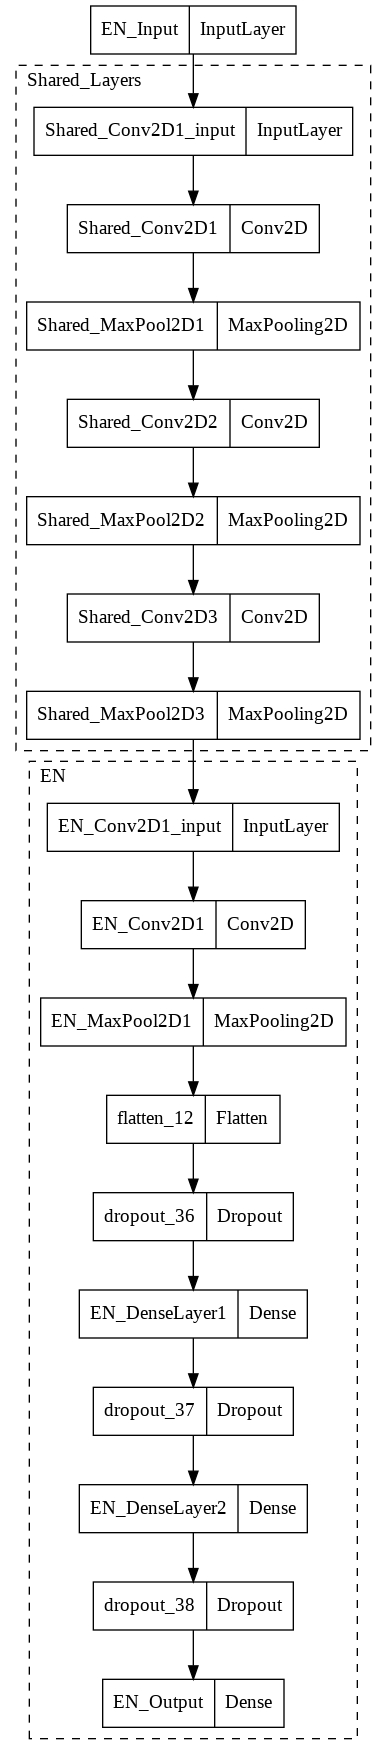

In [122]:
inputEN = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='EN_Input')
inputES = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='ES_Input')
inputFR = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='FR_Input')
inputDE = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='DE_Input')
inputCA = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='CA_Input')

shared = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(9,9), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D1'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D1'),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D2'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D2'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D3'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D3')
    ],
    name='Shared_Layers'
)

sharedLayersEN = shared(inputEN)
sharedLayersES = shared(inputES)
sharedLayersFR = shared(inputFR)
sharedLayersDE = shared(inputDE)
sharedLayersCA = shared(inputCA)

layersEN = languagelayers(NUM_LABELS_EN,'EN')(sharedLayersEN)
layersES = languagelayers(NUM_LABELS_ES,'ES')(sharedLayersES)
layersFR = languagelayers(NUM_LABELS_FR,'FR')(sharedLayersFR)
layersDE = languagelayers(NUM_LABELS_DE,'DE')(sharedLayersDE)
layersCA = languagelayers(NUM_LABELS_CA,'CA')(sharedLayersCA)


modelFullEN = tf.keras.Model(
    inputs=[inputEN],
    outputs=[layersEN],
    name='Full_Model_EN'
)


modelFullEN.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullEN, expand_nested=True)

In [123]:
modelFullEN.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [124]:
RUN = '1'

ext = '-FULL-EN'

training_callbackFULLEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [125]:
# model.predict(testdatasetEN)

In [126]:
historyEN = modelFullEN.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)


Epoch 1/75
36/36 [==============================] - 2s 29ms/step - loss: 2.7474 - Categorical_Accuracy: 0.0778 - AUC: 0.5021 - val_loss: 2.6983 - val_Categorical_Accuracy: 0.1120 - val_AUC: 0.5496 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 10ms/step - loss: 2.7114 - Categorical_Accuracy: 0.0711 - AUC: 0.5357 - val_loss: 2.6920 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5562 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 1s 9ms/step - loss: 2.7073 - Categorical_Accuracy: 0.0756 - AUC: 0.5263 - val_loss: 2.6965 - val_Categorical_Accuracy: 0.1040 - val_AUC: 0.5471 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 1s 9ms/step - loss: 2.6910 - Categorical_Accuracy: 0.0844 - AUC: 0.5532 - val_loss: 2.6850 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5589 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 1s 9ms/step - loss: 2.6952 - Categorical_Accuracy: 0.0944 - AUC: 0.5510 - val_loss: 2.6836 - v

In [127]:
# print(modelFullEN.layers[-2].weights)

Model: "Full_Model_ES"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ES_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

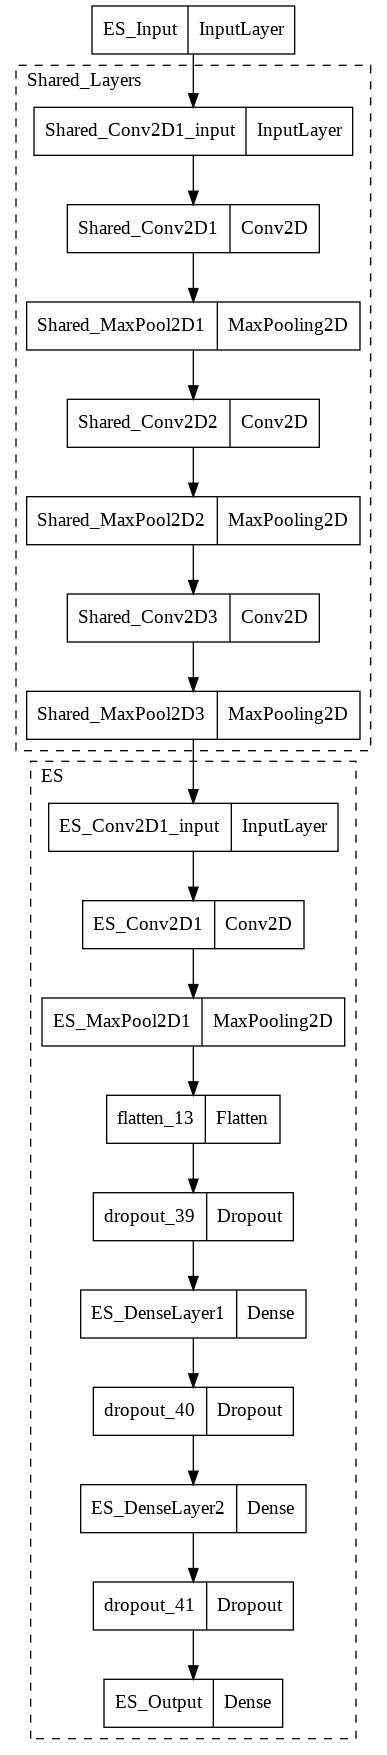

In [128]:
modelFullES = tf.keras.Model(
    inputs=[inputES],
    outputs=[layersES],
    name='Full_Model_ES'
)

modelFullES.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullES, expand_nested=True)

In [129]:
modelFullES.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [130]:
# print(modelFullES.layers[-2].weights)

In [131]:
ext = '-FULL-ES'
training_callbackFULLES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyES = modelFullES.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 28ms/step - loss: 2.4323 - Categorical_Accuracy: 0.0567 - AUC: 0.5153 - val_loss: 2.4437 - val_Categorical_Accuracy: 0.0680 - val_AUC: 0.5267 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 10ms/step - loss: 2.4161 - Categorical_Accuracy: 0.0756 - AUC: 0.5345 - val_loss: 2.4377 - val_Categorical_Accuracy: 0.0560 - val_AUC: 0.5373 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 1s 9ms/step - loss: 2.4113 - Categorical_Accuracy: 0.0844 - AUC: 0.5466 - val_loss: 2.4365 - val_Categorical_Accuracy: 0.0580 - val_AUC: 0.5424 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 1s 9ms/step - loss: 2.4125 - Categorical_Accuracy: 0.0767 - AUC: 0.5379 - val_loss: 2.4327 - val_Categorical_Accuracy: 0.0620 - val_AUC: 0.5358 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 1s 9ms/step - loss: 2.4024 - Categorical_Accuracy: 0.0678 - AUC: 0.5551 - val_loss: 2.4239 - v

Model: "Full_Model_FR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FR_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

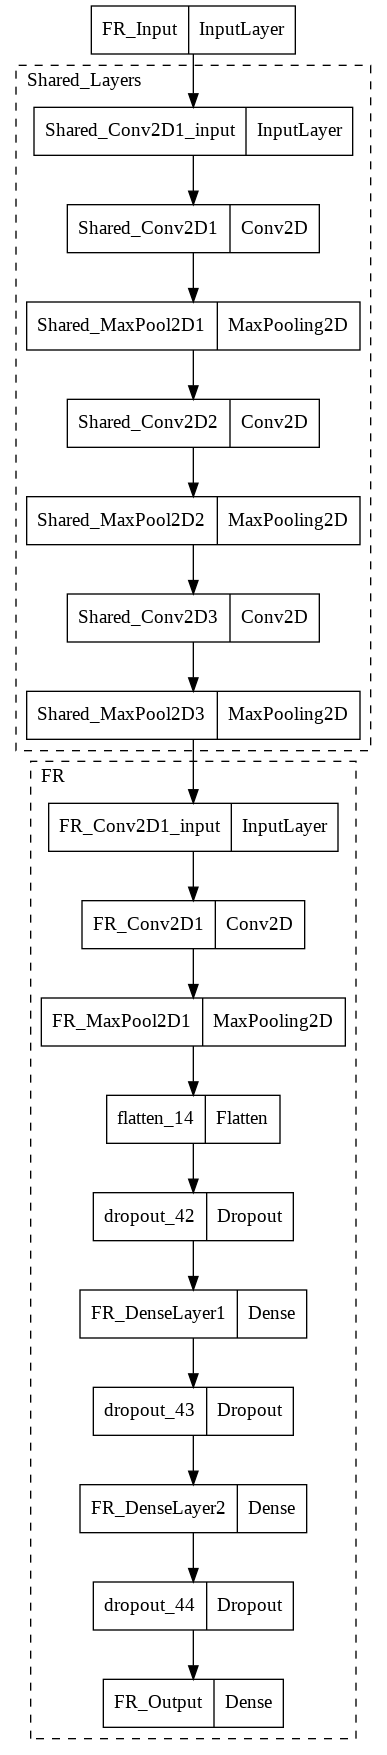

In [132]:
modelFullFR = tf.keras.Model(
    inputs=[inputFR],
    outputs=[layersFR],
    name='Full_Model_FR'
)

modelFullFR.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullFR, expand_nested=True)

In [133]:
modelFullFR.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [134]:
ext = '-FULL-FR'
training_callbackFULLFR = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyFR = modelFullFR.fit(
    x = traindatasetFR,
    validation_data = valdatasetFR,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLFR,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 29ms/step - loss: 2.7300 - Categorical_Accuracy: 0.0656 - AUC: 0.5058 - val_loss: 2.6949 - val_Categorical_Accuracy: 0.0700 - val_AUC: 0.5455 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 10ms/step - loss: 2.7133 - Categorical_Accuracy: 0.0744 - AUC: 0.5190 - val_loss: 2.6897 - val_Categorical_Accuracy: 0.1040 - val_AUC: 0.5717 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 1s 9ms/step - loss: 2.7065 - Categorical_Accuracy: 0.0644 - AUC: 0.5246 - val_loss: 2.6825 - val_Categorical_Accuracy: 0.1140 - val_AUC: 0.5784 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 1s 9ms/step - loss: 2.6939 - Categorical_Accuracy: 0.0889 - AUC: 0.5450 - val_loss: 2.6777 - val_Categorical_Accuracy: 0.1220 - val_AUC: 0.5959 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 1s 9ms/step - loss: 2.6903 - Categorical_Accuracy: 0.0889 - AUC: 0.5472 - val_loss: 2.6672 - v

Model: "Full_Model_DE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DE_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

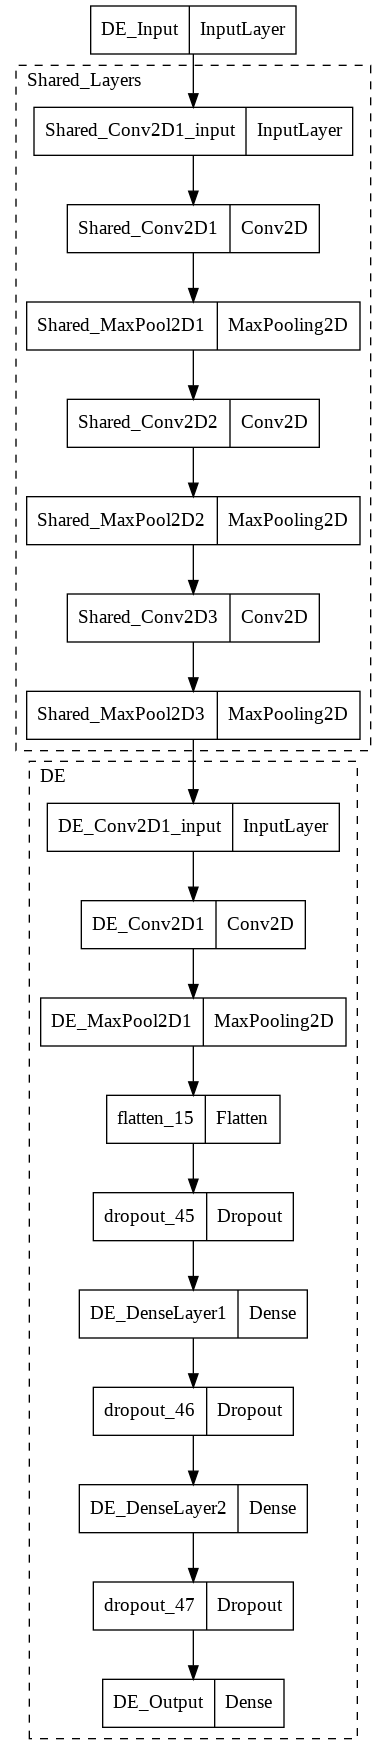

In [135]:
modelFullDE = tf.keras.Model(
    inputs=[inputDE],
    outputs=[layersDE],
    name='Full_Model_DE'
)

modelFullDE.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullDE, expand_nested=True)

In [136]:
modelFullDE.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [137]:
ext = '-FULL-DE'
training_callbackFULLDE = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyDE = modelFullDE.fit(
    x = traindatasetDE,
    validation_data = valdatasetDE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLDE,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 28ms/step - loss: 2.8123 - Categorical_Accuracy: 0.0678 - AUC: 0.4973 - val_loss: 2.6893 - val_Categorical_Accuracy: 0.0480 - val_AUC: 0.5704 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 9ms/step - loss: 2.7084 - Categorical_Accuracy: 0.0767 - AUC: 0.5396 - val_loss: 2.6767 - val_Categorical_Accuracy: 0.0680 - val_AUC: 0.5927 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 1s 9ms/step - loss: 2.6920 - Categorical_Accuracy: 0.0800 - AUC: 0.5561 - val_loss: 2.6736 - val_Categorical_Accuracy: 0.0700 - val_AUC: 0.6199 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 1s 10ms/step - loss: 2.6842 - Categorical_Accuracy: 0.0989 - AUC: 0.5618 - val_loss: 2.6645 - val_Categorical_Accuracy: 0.0940 - val_AUC: 0.6350 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 1s 9ms/step - loss: 2.6607 - Categorical_Accuracy: 0.1044 - AUC: 0.5877 - val_loss: 2.6434 - v

Model: "Full_Model_CA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CA_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

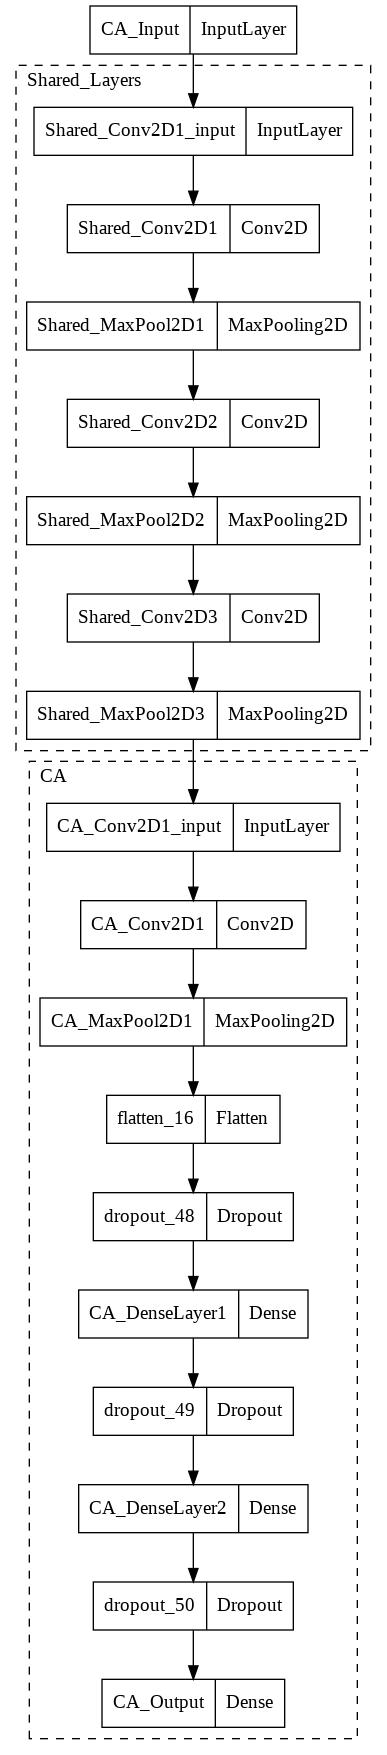

In [138]:
modelFullCA = tf.keras.Model(
    inputs=[inputCA],
    outputs=[layersCA],
    name='Full_Model_CA'
)

modelFullCA.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullCA, expand_nested=True)

In [139]:
modelFullCA.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [140]:
ext = '-FULL-CA'
training_callbackFULLCA = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyCA = modelFullCA.fit(
    x = traindatasetCA,
    validation_data = valdatasetCA,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLCA,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 29ms/step - loss: 2.7904 - Categorical_Accuracy: 0.0833 - AUC: 0.5099 - val_loss: 2.6240 - val_Categorical_Accuracy: 0.1120 - val_AUC: 0.5596 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 9ms/step - loss: 2.6710 - Categorical_Accuracy: 0.0778 - AUC: 0.5241 - val_loss: 2.6221 - val_Categorical_Accuracy: 0.1040 - val_AUC: 0.5823 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 1s 9ms/step - loss: 2.6348 - Categorical_Accuracy: 0.0856 - AUC: 0.5500 - val_loss: 2.6114 - val_Categorical_Accuracy: 0.1440 - val_AUC: 0.6301 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 1s 9ms/step - loss: 2.6038 - Categorical_Accuracy: 0.1111 - AUC: 0.5730 - val_loss: 2.5925 - val_Categorical_Accuracy: 0.2060 - val_AUC: 0.6796 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 1s 10ms/step - loss: 2.5678 - Categorical_Accuracy: 0.1200 - AUC: 0.6090 - val_loss: 2.5450 - v

In [141]:
shared.trainable = False

In [142]:
newSharedLayers = shared(inputEN)
newLayersEN = languagelayers(NUM_LABELS_EN,'EN')(newSharedLayers)

modelENRetrain = tf.keras.Model(
    inputs=inputEN,
    outputs=newLayersEN,
    name='ENModelRetrained'
)

In [143]:
modelENRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

# modelEN.evaluate(testdatasetEN)

In [144]:
ext = '-RETRAIN-EN'
training_callbackRETRAINEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyENRetrain = modelENRetrain.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 19ms/step - loss: 3.1784 - Categorical Accuracy: 0.0656 - AUC: 0.5282 - val_loss: 2.6430 - val_Categorical Accuracy: 0.1340 - val_AUC: 0.6231 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 8ms/step - loss: 2.8675 - Categorical Accuracy: 0.0967 - AUC: 0.5421 - val_loss: 2.6183 - val_Categorical Accuracy: 0.1840 - val_AUC: 0.6887 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 0s 8ms/step - loss: 2.7659 - Categorical Accuracy: 0.1089 - AUC: 0.5512 - val_loss: 2.6025 - val_Categorical Accuracy: 0.2220 - val_AUC: 0.7222 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 0s 8ms/step - loss: 2.6886 - Categorical Accuracy: 0.1233 - AUC: 0.5858 - val_loss: 2.5876 - val_Categorical Accuracy: 0.2320 - val_AUC: 0.7307 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 0s 8ms/step - loss: 2.6198 - Categorical Accuracy: 0.1322 - AUC: 0.6161 - val_loss: 2.5471 - va

In [145]:
# print(modelENRetrain.layers[-2].weights)

In [146]:
newSharedLayers = shared(inputES)
newLayersES = languagelayers(NUM_LABELS_ES,'ES')(newSharedLayers)

modelESRetrain = tf.keras.Model(
    inputs=inputES,
    outputs=newLayersES,
    name='ESModelRetrained'
)

modelESRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-ES'
training_callbackRETRAINES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyESRetrain = modelESRetrain.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 36ms/step - loss: 2.8358 - Categorical Accuracy: 0.0789 - AUC: 0.5049 - val_loss: 2.3944 - val_Categorical Accuracy: 0.1520 - val_AUC: 0.6082 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 8ms/step - loss: 2.4706 - Categorical Accuracy: 0.1044 - AUC: 0.5589 - val_loss: 2.3728 - val_Categorical Accuracy: 0.1960 - val_AUC: 0.6886 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 0s 8ms/step - loss: 2.4401 - Categorical Accuracy: 0.0856 - AUC: 0.5627 - val_loss: 2.3386 - val_Categorical Accuracy: 0.2220 - val_AUC: 0.7264 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 0s 8ms/step - loss: 2.3723 - Categorical Accuracy: 0.1156 - AUC: 0.6042 - val_loss: 2.2987 - val_Categorical Accuracy: 0.2680 - val_AUC: 0.7541 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 0s 8ms/step - loss: 2.3329 - Categorical Accuracy: 0.1456 - AUC: 0.6228 - val_loss: 2.2569 - va

In [147]:
newSharedLayers = shared(inputFR)
newLayersFR = languagelayers(NUM_LABELS_FR,'FR')(newSharedLayers)

modelFRRetrain = tf.keras.Model(
    inputs=inputFR,
    outputs=newLayersFR,
    name='FRModelRetrained'
)

modelFRRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-FR'
training_callbackRETRAINFR = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyFRRetrain = modelFRRetrain.fit(
    x = traindatasetFR,
    validation_data = valdatasetFR,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINFR,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 19ms/step - loss: 3.2685 - Categorical Accuracy: 0.0744 - AUC: 0.5137 - val_loss: 2.6758 - val_Categorical Accuracy: 0.1100 - val_AUC: 0.5777 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 8ms/step - loss: 2.8467 - Categorical Accuracy: 0.0844 - AUC: 0.5424 - val_loss: 2.6390 - val_Categorical Accuracy: 0.1880 - val_AUC: 0.6381 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 0s 8ms/step - loss: 2.7331 - Categorical Accuracy: 0.0922 - AUC: 0.5744 - val_loss: 2.6194 - val_Categorical Accuracy: 0.2220 - val_AUC: 0.6838 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 0s 8ms/step - loss: 2.7017 - Categorical Accuracy: 0.1067 - AUC: 0.5829 - val_loss: 2.6018 - val_Categorical Accuracy: 0.2240 - val_AUC: 0.7060 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 1s 8ms/step - loss: 2.6548 - Categorical Accuracy: 0.1200 - AUC: 0.6027 - val_loss: 2.5817 - va

In [148]:
newSharedLayers = shared(inputDE)
newLayersDE = languagelayers(NUM_LABELS_DE,'DE')(newSharedLayers)

modelDERetrain = tf.keras.Model(
    inputs=inputDE,
    outputs=newLayersDE,
    name='DEModelRetrained'
)

modelDERetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-DE'
training_callbackRETRAINDE = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyDERetrain = modelDERetrain.fit(
    x = traindatasetDE,
    validation_data = valdatasetDE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINDE,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 19ms/step - loss: 3.0967 - Categorical Accuracy: 0.0700 - AUC: 0.5060 - val_loss: 2.6546 - val_Categorical Accuracy: 0.1260 - val_AUC: 0.6373 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 8ms/step - loss: 2.8045 - Categorical Accuracy: 0.0956 - AUC: 0.5462 - val_loss: 2.6135 - val_Categorical Accuracy: 0.2100 - val_AUC: 0.7107 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 0s 8ms/step - loss: 2.6877 - Categorical Accuracy: 0.0989 - AUC: 0.5897 - val_loss: 2.5619 - val_Categorical Accuracy: 0.2780 - val_AUC: 0.7683 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 0s 8ms/step - loss: 2.6104 - Categorical Accuracy: 0.1378 - AUC: 0.6242 - val_loss: 2.5180 - val_Categorical Accuracy: 0.3000 - val_AUC: 0.7899 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 0s 8ms/step - loss: 2.5646 - Categorical Accuracy: 0.1433 - AUC: 0.6556 - val_loss: 2.4533 - va

In [149]:
newSharedLayers = shared(inputCA)
newLayersCA = languagelayers(NUM_LABELS_CA,'CA')(newSharedLayers)

modelCARetrain = tf.keras.Model(
    inputs=inputCA,
    outputs=newLayersCA,
    name='CAModelRetrained'
)

modelCARetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-CA'
training_callbackRETRAINCA = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyCARetrain = modelCARetrain.fit(
    x = traindatasetCA,
    validation_data = valdatasetCA,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINCA,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
36/36 [==============================] - 2s 18ms/step - loss: 3.2223 - Categorical Accuracy: 0.0900 - AUC: 0.5171 - val_loss: 2.5712 - val_Categorical Accuracy: 0.1780 - val_AUC: 0.6298 - lr: 1.0000e-04
Epoch 2/75
36/36 [==============================] - 0s 8ms/step - loss: 2.7792 - Categorical Accuracy: 0.0900 - AUC: 0.5503 - val_loss: 2.5463 - val_Categorical Accuracy: 0.2260 - val_AUC: 0.6913 - lr: 1.0000e-04
Epoch 3/75
36/36 [==============================] - 0s 8ms/step - loss: 2.6732 - Categorical Accuracy: 0.1211 - AUC: 0.5689 - val_loss: 2.5235 - val_Categorical Accuracy: 0.2740 - val_AUC: 0.7442 - lr: 1.0000e-04
Epoch 4/75
36/36 [==============================] - 0s 8ms/step - loss: 2.6178 - Categorical Accuracy: 0.1022 - AUC: 0.5920 - val_loss: 2.4886 - val_Categorical Accuracy: 0.3180 - val_AUC: 0.7830 - lr: 1.0000e-04
Epoch 5/75
36/36 [==============================] - 1s 8ms/step - loss: 2.5025 - Categorical Accuracy: 0.1600 - AUC: 0.6490 - val_loss: 2.4333 - va

In [150]:
modelENRetrain.evaluate(testdatasetEN)

250/250 [==============================] - 4s 10ms/step - loss: 0.9629 - Categorical Accuracy: 0.6640 - AUC: 0.9653


[0.9628928303718567, 0.6639999747276306, 0.9652811884880066]

In [151]:
modelESRetrain.evaluate(testdatasetES)

250/250 [==============================] - 1s 4ms/step - loss: 0.7529 - Categorical Accuracy: 0.7120 - AUC: 0.9700


[0.752926230430603, 0.7120000123977661, 0.970034122467041]

In [152]:
modelFRRetrain.evaluate(testdatasetFR)

250/250 [==============================] - 1s 4ms/step - loss: 0.9559 - Categorical Accuracy: 0.6480 - AUC: 0.9680


[0.9558636546134949, 0.6480000019073486, 0.9679862856864929]

In [153]:
modelDERetrain.evaluate(testdatasetDE)

250/250 [==============================] - 1s 4ms/step - loss: 1.1409 - Categorical Accuracy: 0.6160 - AUC: 0.9501


[1.1408854722976685, 0.6159999966621399, 0.9500547647476196]

In [154]:
modelCARetrain.evaluate(testdatasetCA)

250/250 [==============================] - 1s 4ms/step - loss: 0.6115 - Categorical Accuracy: 0.7960 - AUC: 0.9870


[0.6114996671676636, 0.7960000038146973, 0.9869875907897949]

In [155]:
# !rm -r savedmodels

In [156]:
# !rm /content/savedmodels.zip
# !mkdir savedmodels

In [163]:
shared.save('savedmodels/sharedmodel')
modelFullEN.save('savedmodels/fullmodelEN')
modelFullES.save('savedmodels/fullmodelES')
modelFullFR.save('savedmodels/fullmodelFR')
modelFullDE.save('savedmodels/fullmodelDE')
modelFullCA.save('savedmodels/fullmodelCA')
modelENRetrain.save('savedmodels/modelENRetrain')
modelESRetrain.save('savedmodels/modelESRetrain')
modelFRRetrain.save('savedmodels/modelFRRetrain')
modelDERetrain.save('savedmodels/modelDERetrain')
modelCARetrain.save('savedmodels/modelCARetrain')

INFO:tensorflow:Assets written to: savedmodels/sharedmodel/assets


INFO:tensorflow:Assets written to: savedmodels/sharedmodel/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelEN/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelEN/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelES/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelES/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelFR/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelFR/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelDE/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelDE/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelCA/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelCA/assets


INFO:tensorflow:Assets written to: savedmodels/modelENRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelENRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelESRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelESRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelFRRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelFRRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelDERetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelDERetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelCARetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelCARetrain/assets


In [164]:
# !zip -r /content/savedmodels.zip /content/savedmodels
#

  adding: content/savedmodels/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/keras_metadata.pb (deflated 94%)
  adding: content/savedmodels/fullmodelEN/variables/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/variables/variables.index (deflated 68%)
  adding: content/savedmodels/fullmodelEN/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/savedmodels/fullmodelEN/saved_model.pb (deflated 90%)
  adding: content/savedmodels/fullmodelEN/assets/ (stored 0%)
  adding: content/savedmodels/sharedmodel/ (stored 0%)
  adding: content/savedmodels/sharedmodel/keras_metadata.pb (deflated 92%)
  adding: content/savedmodels/sharedmodel/variables/ (stored 0%)
  adding: content/savedmodels/sharedmodel/variables/variables.index (deflated 46%)
  adding: content/savedmodels/sharedmodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/savedmodels/sharedmodel/saved_model.pb (deflated 90%)
  a

In [165]:
# from google.colab import files
# files.download('/content/savedmodels.zip')
#

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [160]:
# # %reload_ext tensorboard
# # %tensorboard --logdir logs
#

In [166]:
# # !rm logs.zip
# !zip -r /content/logs.zip /content/logs
#

  adding: content/logs/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/train/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/train/events.out.tfevents.1638887909.56958702cbb5.85.30.v2 (deflated 86%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/events.out.tfevents.1638887910.56958702cbb5.85.31.v2 (deflated 80%)
  adding: content/logs/model1-1-RETRAIN-ES/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/train/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/train/events.out.tfevents.1638887943.56958702cbb5.85.32.v2 (deflated 86%)
  adding: content/logs/model1-1-RETRAIN-ES/validation/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/validation/events.out.tfevents.1638887944.56958702cbb5.85.33.v2 (deflated 80%)
  adding: content/logs/model1-1-RETRAIN-FR/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-FR/train/ (stored 0%

In [168]:
# from google.colab import files
# files.download('/content/logs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>